## Latent variable models and pseudotime

In this notebook we will go through what we mean by "pseudotime". And the relation between latent variables and clustering.

In [1]:
%pylab inline
%run ../scrnatb/scrnatb/toolbox.py

Populating the interactive namespace from numpy and matplotlib


What's a cluster?

Many definitions, but:

"A group so that distances between the members of the group are closer to each other than to members of other groups."

In [2]:
%run ../scrnatb/scrnatb/gp_utils.py

<IPython.core.display.Javascript object>


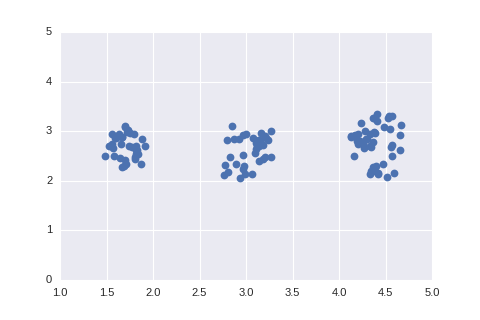

In [200]:
%matplotlib notebook
fig, ax = plt.subplots(1,1);

plt.xlim(1, 5)
plt.ylim(0, 5)

cc = point_sprayer(ax, std=0.08)

In [201]:
%matplotlib inline
XY = cc.return_points().T
XY.shape

(117, 2)

In [202]:
from sklearn.cluster import KMeans

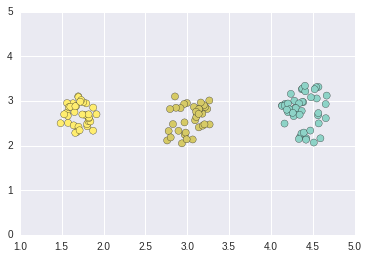

In [210]:
kmeans = KMeans(n_clusters=3)
cluster = kmeans.fit_predict(XY)
plt.scatter(*XY.T, c=cluster, cmap=cm.Set3, s=50)
plt.xlim(1, 5)
plt.ylim(0, 5);

We are willing to partition data and assign meaning in this way about distance.

What about contiguous data, like this?

<IPython.core.display.Javascript object>


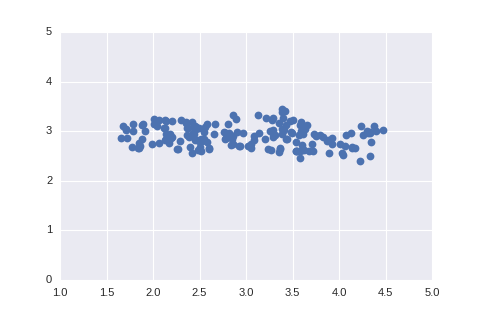

In [216]:
%matplotlib notebook
fig, ax = plt.subplots(1,1);

plt.xlim(1, 5)
plt.ylim(0, 5)

cc = point_sprayer(ax, std=0.08)

In [217]:
%matplotlib inline
XY = cc.return_points().T
XY.shape

(174, 2)

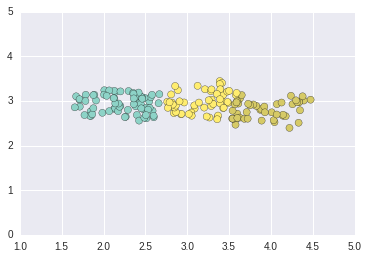

In [218]:
kmeans = KMeans(n_clusters=3)
cluster = kmeans.fit_predict(XY)
plt.scatter(*XY.T, c=cluster, cmap=cm.Set3, s=50)
plt.xlim(1, 5)
plt.ylim(0, 5);

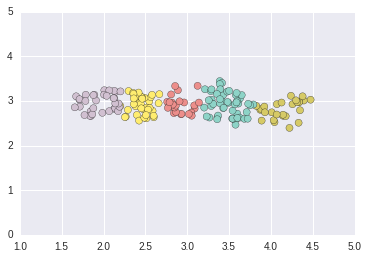

In [219]:
kmeans = KMeans(n_clusters=5)
cluster = kmeans.fit_predict(XY)
plt.scatter(*XY.T, c=cluster, cmap=cm.Set3, s=50)
plt.xlim(1, 5)
plt.ylim(0, 5);

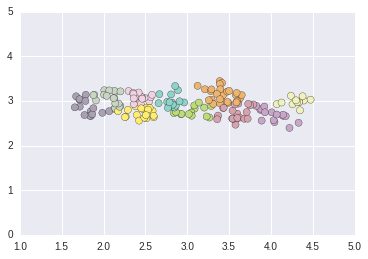

In [220]:
kmeans = KMeans(n_clusters=10)
cluster = kmeans.fit_predict(XY)
plt.scatter(*XY.T, c=cluster, cmap=cm.Set3, s=50)
plt.xlim(1, 5)
plt.ylim(0, 5);

A rather large problem in machine learning / statistics in general, is how to pick the number of clusters for clustering algorithms. Above we can see by eye that 3 clusters would be good. Here though, by design, there is nothing one would consider a cluster separation.

Yet, the data could be partitioned into groups by clustering. The key is that it wouldn't matter how many clusters we would want to find.

And clearly, some clusters will be closer to each other than other clusters.

We conclude that putting the data in to discrete categories is not what we are interested in. We want a _continous variable_, that we did not observe, which describe the data.

For data like above, this problem was solved by PCA 100 years ago. (Karl Pearson 1901, Harald Hotelling ~1930 indep)

(One can even show that PCA is equivalent to K-means clustering with an infinite number of clusters)

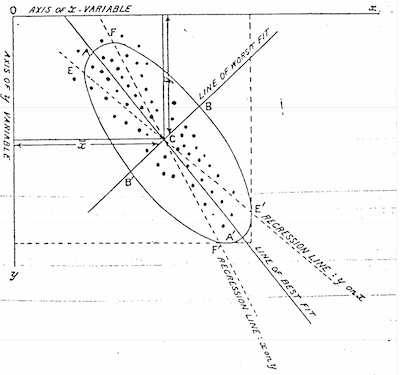

In [223]:
from IPython.display import Image
Image(filename='img/pearson-pca.png')

But what about when the data has a shape which is not a nice flat thing?

<IPython.core.display.Javascript object>


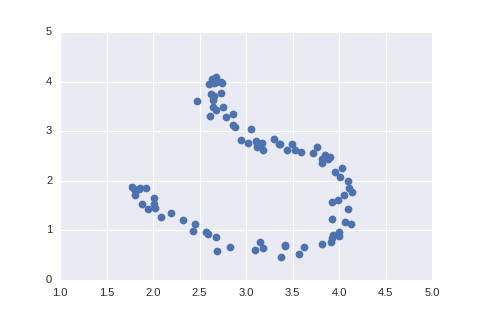

In [53]:
%matplotlib notebook
fig, ax = plt.subplots(1,1);

plt.xlim(1, 5)
plt.ylim(0, 5)

cc = point_sprayer(ax, std=0.08)

In [54]:
%matplotlib inline
XY = cc.return_points().T
XY.shape

(94, 2)

Since PCA is a linear projection, it will not be able to "unfold" this structure.

There are many graph based ways of dealing with this. For example the bioinformatics tools Wanderlust uses a kNN graph between the points, and find the closest path along the graph between points. This gives a parametrization for the points (using a given point as 0). Monocle does the same thing, but uses as Minimum Spanning Tree in stead of kNN graph.

Another strategy is to use spectral embeddings, such as Diffusion Maps.

We will use a **Baysian Gaussian Process Latent Variable Model**

The derivation of a GPLVM is somewhat involved and out od scope for this section.

To get a gist of it. Say we have multiple Gaussian Processes, here two, mapping from X (here 1-dimensional) to Y_0 and Y_1.

In section 1, we said that the hyper parameter for a Gaussian process can be optimized in terms of the likelihood. It turns out, when we have multiple GPs at the same time, that in the same way the X-values of the model can be optimized!

We can find the X-values, such that the combined Y-values are well explained by Gaussian Processes to the Y-values.

The value of doing this rather than another method, are
 - GPLVMs can model more dimensions than observations without overfitting
 - Choice of covariance function allows flexibility. RBF is a good non-linear one usually.
 - Likelihood gives quantitative value of how good the model is
 - Can predict and generate high-dimensional data
 - Can measure uncertainty of the model

In addition, the Bayesian version of GPLVM offers
 - Improved performance by inducing inputs
 - Can measure uncertainty of _X-values_
 
It also matches well with the physical world: Given an observed trajectory, we assume it has been generated by a noisy low-dimensional process.

In [61]:
import GPy

Here we assume that the latent low-dimensional space is 1-dimensional. So we are saying that there should be a 1-dimensional parametrization of the point pattern we drew based on two Gaussian Processes.

In [134]:
m = GPy.models.BayesianGPLVM(XY, input_dim=1)

In [135]:
m.optimize(messages=True)

In [224]:
m

bayesian_gplvm.,value,constraints,priors
latent space.mean,"(94, 1)",,
latent space.variance,"(94, 1)",+ve,
inducing inputs,"(10, 1)",,
Gaussian_noise.variance,0.00616009873741,+ve,


Let us plot the input points colored by inferred 1-dimensional variable

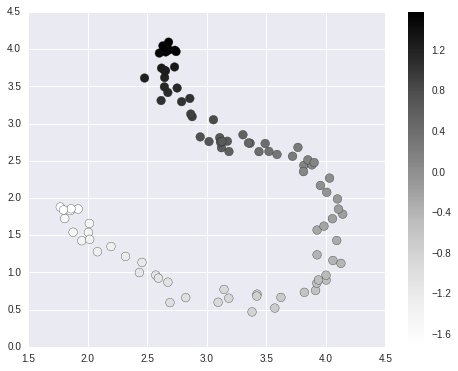

In [136]:
figsize(8, 6)
plt.scatter(*XY.T, c=m.X.mean, s=75);
plt.colorbar();

We have identified the X-values in a way which looks sensible. Note that there is no way for the model to know what is start and what is end of the curve. This is not a limitation of the model, it is just a simple fact of curves.

What does the underlying trend explaining the data actually look like according to the model?

In [137]:
Xnew = np.linspace(m.X.mean.min(), m.X.mean.max())[:, None]
Ynew = m.predict(Xnew)[0]

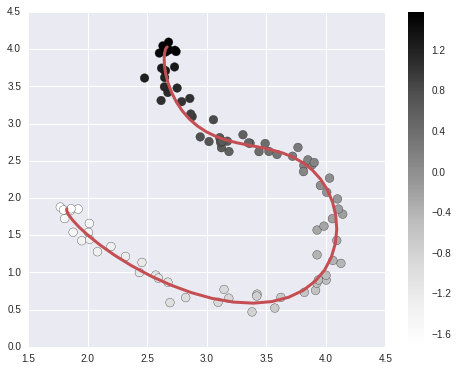

In [138]:
plt.scatter(*XY.T, c=m.X.mean, s=75);
plt.colorbar();
plt.plot(*Ynew.T, lw=3, c='r');

This is very nice smooth curve which likely mimics my hand movement as I drew the shape.

How certain is the curve? Making confidence intervals in 2D is tricky. We can visualize the confidence intervals by sampling from the posterior.

(Recall that the curve we are showing above is the mean of the posterior)

In [139]:
mu, va = m.predict(Xnew, full_cov=True)
size = 100
samples = []
for i in range(mu.shape[1]):
    smp = np.random.multivariate_normal(mean=mu[:, i], cov=va, size=size)
    samples.append(smp)

samples = np.stack(samples, -1)

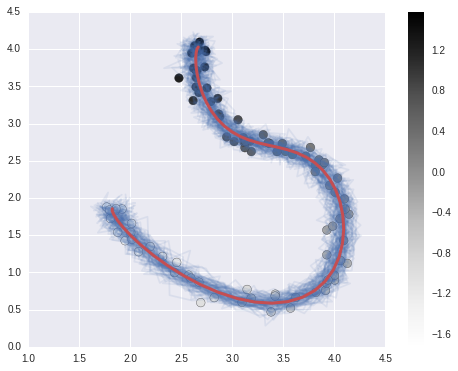

In [140]:
plt.scatter(*XY.T, c=m.X.mean, s=75);
plt.colorbar();
for s in samples:
    plt.plot(*s.T, c='b', alpha=0.1)
    
plt.plot(*Ynew.T, lw=3, c='r');

## how does this relate to Single Cell Time courses?

When we sample single cells from a time point in e.g. a stimulation experiment, we invariably see that the cells inside that time point are **heterogenous**. In fact, almost every single cell paper is about how heterogeneous populations of cells are. This makes sense, why else would you bother studying single cells?

But _what do we mean_ when we say cells are heterogenous within a condition? (e.g. at hour 2 of a stimulation)

From the point of view of trying to describe the data with a model, this means **some aspect of the data is not being properly modelled**.

One likely source of variation inside a time point, is that cells are not perfectly synchronized. Within a time point, some cells will have gotten "further" responding than others.

The great contribution by Trapnell et al 2014 (Monocle) was to point out that using latent variable techniques, such within-contidion variations can be detected, and considered in the analysis in a meaningful way.

I like to think of each time point in an single cell experiment as a **shotgun time-course**.

Analogous to shoutgun sequencing, where we sequence fragments of a genome, and assemble them computationally to a genome. We can measure transcriptomes of samples, and infer based on their similarites, the process that would explain the data.

Note that this is completely the same as clustering. In the clustering case, you measure a group of single cells, and you conclude that they are heterogenous within that group. By clustering, you are trying to explain the heterogeneity by assigning cells to sub-groups, thus improving the model of your data.

The difference here is that clustering puts discrete values on cells, while latent variables (or "_pseudotime_") puts continuous values on them.

#### _Appendix_: What happens if we remove a slice, in terms of uncertainty?

In [186]:
mask = ~((XY[:, 0] > 3.5) & (XY[:, 1] > 0.) & (XY[:, 1] < 3.))

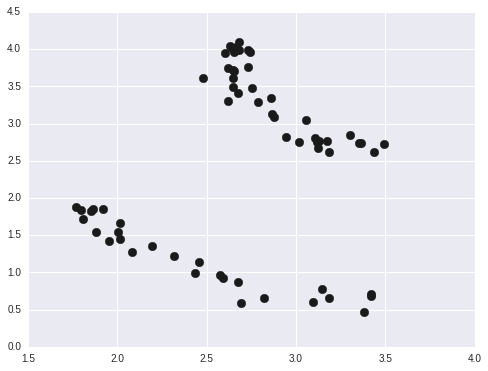

In [187]:
plt.scatter(*XY[mask].T, c='k', s=75);

In [188]:
m2 = GPy.models.BayesianGPLVM(XY[mask],
                              input_dim=1,
                              kernel=m.kern,
                              X=np.array(m.X.mean[mask]),
                              X_variance=np.array(m.X.variance[mask]))
m2.Gaussian_noise.variance = m.Gaussian_noise.variance

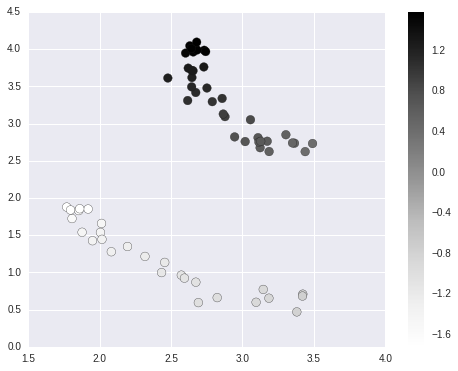

In [189]:
figsize(8, 6)
plt.scatter(*XY[mask].T, c=m2.X.mean, s=75);
plt.colorbar();

In [190]:
mu, va = m2.predict(Xnew, full_cov=True)
size = 100
samples = []
for i in range(mu.shape[1]):
    smp = np.random.multivariate_normal(mean=mu[:, i], cov=va, size=size)
    samples.append(smp)

samples = np.stack(samples, -1)

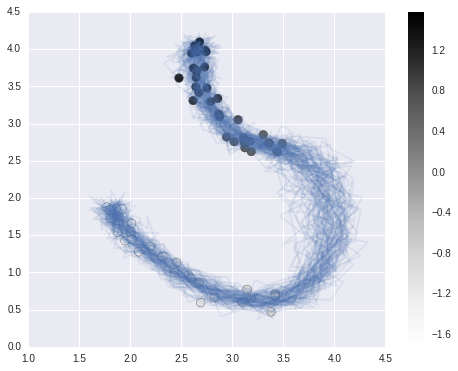

In [192]:
plt.scatter(*XY[mask].T, c=m2.X.mean, s=75);
plt.colorbar();
for s in samples:
    plt.plot(*s.T, c='b', alpha=0.1)


In [195]:
mu, va = m.predict(Xnew, full_cov=True)
size = 100
samples = []
for i in range(mu.shape[1]):
    smp = np.random.multivariate_normal(mean=mu[:, i], cov=va, size=size)
    samples.append(smp)

samples = np.stack(samples, -1)

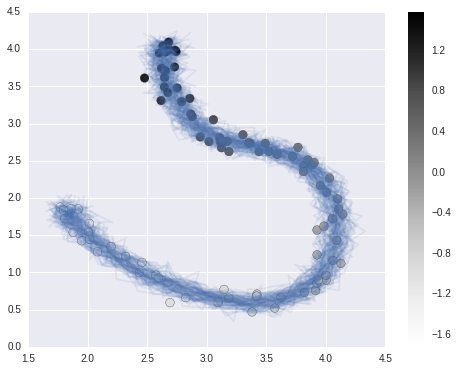

In [197]:
plt.scatter(*XY.T, c=m.X.mean, s=75);
plt.colorbar();
for s in samples:
    plt.plot(*s.T, c='b', alpha=0.1)
